In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTMAEConfig, ViTConfig, ViTMAEModel, ViTImageProcessor, TrainingArguments, Trainer
from PIL import Image
import matplotlib.pyplot as plt
import requests
from datasets import load_dataset
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import logging 
logging.basicConfig(level=logging.DEBUG, filename='logs/train.log', filemode='w', format='%(message)s')

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device


/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda:0'

In [2]:
def count_model_size(model):
    size = 0
    for name, param in model.named_parameters():
        size += param.numel()
    return size

In [3]:
vit_classifier = ViTForImageClassification.from_pretrained('facebook/vit-mae-base', num_labels=10)
count_model_size(vit_classifier)

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85806346

In [4]:
model = torchvision.models.resnet152(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
count_model_size(model)


/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


58164298

In [5]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=4)

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# for param in model.parameters():
#     param.requires_grad = False
# for name, param in model.fc.named_parameters():
#     param.requires_grad = True

# Check if only the last layer is tunable
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


model = model.to(device)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 20
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [8]:
def evaluate_model(loader):
    num_correct = 0
    total = 0
    eval_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader, 0), total=len(loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels).item()
            eval_loss += loss
            prediction = outputs.argmax(dim=-1)

            total += prediction.size(0)
            num_correct += (prediction == labels).sum().item()
    return eval_loss/len(loader), num_correct / total


In [9]:
train_losses = []
test_losses = []
test_acc = []

In [10]:
train_losses = np.load('train_losses.npy').tolist()
test_losses = np.load('test_losses.npy').tolist()
test_acc= np.load('test_correctness.npy').tolist()

In [11]:
# Train
train_loss_count_freq = 100
test_loss_min = np.Inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    # avg_train_loss = 0.0
    train_loss_buffer = []
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss_buffer.append(loss.item())
        if i % train_loss_count_freq == (train_loss_count_freq - 1):
            mean_train_loss = np.mean(train_loss_buffer)
            logging.debug(f'[{epoch + 1}, {i + 1:5d}] train loss: {mean_train_loss}')
            train_losses.append(mean_train_loss)
            train_loss_buffer.clear()
    
    
    # Evaluate on validation and test set
    model.eval()
    test_loss, correctness_test = evaluate_model(testloader)

    test_losses.append(test_loss)
    test_acc.append(correctness_test)

    # avg_train_loss = 0.0    
    logging.debug(f'[{epoch + 1}, {i + 1:5d}] train loss: {train_losses[-1]:.3f}, valid_loss: {test_loss:.3f}, acc: {correctness_test*100}%, lr={optimizer.param_groups[0]["lr"]}')

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        logging.debug('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_loss))
        
        torch.save(model.state_dict(), 'model_cifar.pt')
        test_loss_min = test_loss

    train_losses_t = np.array(train_losses)
    test_losses_t = np.array(test_losses)
    np.save('train_losses.npy', train_losses_t)
    np.save('test_losses.npy', test_losses_t)
    np.save('test_correctness.npy', test_acc)

    scheduler.step()

print('Finished Training')

  0%|          | 0/1563 [00:00<?, ?it/s]

/home/jiachenyuan/miniconda3/envs/cs444env/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 313/313 [00:27<00:00, 11.21it/s]

Finished Training


In [12]:
model.eval()
evaluate_model(testloader)

  3%|▎         | 9/313 [00:00<00:27, 11.03it/s]

100%|██████████| 313/313 [00:27<00:00, 11.18it/s]


(0.08433640342940425, 0.9796)

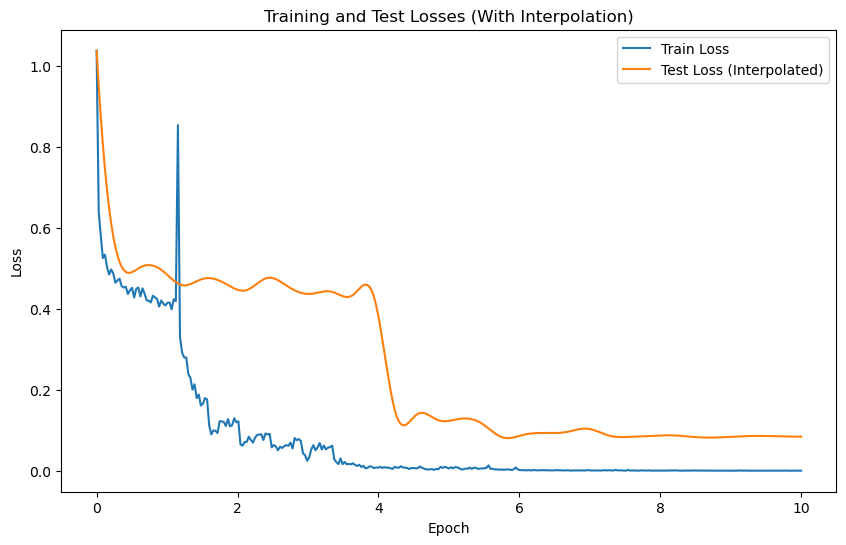

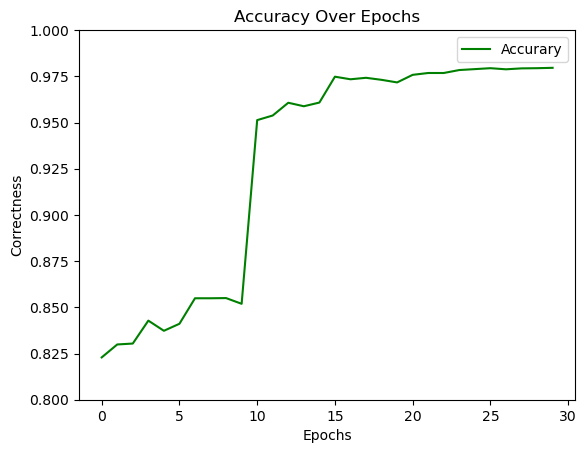

In [13]:
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d

train_losses = np.load('train_losses.npy')
test_losses = np.load('test_losses.npy')
test_acc = np.load('test_correctness.npy')

test_losses = np.insert(test_losses, 0, train_losses[0])
len_train_losses = len(train_losses)
len_test_losses = len(test_losses)

# Interpolating the test losses
x_rescaled = np.linspace(0, 10, num=len_train_losses)
x_test = np.linspace(0, len_train_losses-1, num=len_test_losses) # Original x-axis for test losses
f = interp1d(x_test, test_losses, kind='cubic')
x_new = np.arange(0, len_train_losses) # New x-axis for interpolated test losses
test_losses_interp = f(x_new)

# Plotting the interpolated test losses with the train losses
plt.figure(figsize=(10, 6))
plt.plot(x_rescaled, train_losses, label='Train Loss')
plt.plot(x_rescaled, test_losses_interp, label='Test Loss (Interpolated)')
plt.title('Training and Test Losses (With Interpolation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xlim(0, 10)
plt.legend()
plt.show()

# # Plotting the accuracy
# plt.figure(figsize=(10, 6))
# test_acc = np.insert(test_acc, 0, 0.75)
# f_acc = interp1d(x_test, test_acc, kind='cubic')
# test_acc_interp = f_acc(x_new)


# print(len(x_rescaled), len(test_acc_interp))
window_size = 1 
test_correctness_smoothed = uniform_filter1d(test_acc, size=window_size, mode='nearest')
plt.plot(test_correctness_smoothed, label='Accurary', color='green')

# Adding title and labels
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Correctness')
plt.ylim(0.8, 1)
# plt.xlim(0, 10)
# Adding legend
plt.legend()

# Show the plot
plt.show()


